# Visualizing protein sequence space as a hierarchical cluster plot


This notebook showcases how to analyze a protein family as series of hierarchical clusters.

**Required:** Run the [**run pipeline**](./run_pipeline.ipynb) notebook first to make sure the required outputs are present.    

## Step 1. Identify levels of interest and build layout
Can skip if done once and saved.  

In [5]:
import pickle
from proteinclustertools.layout.circle_layout_tools import Box2DLayout
import re
import os
import pandas as pd

Choose which analysis (homology, kmeans, hierarchical clustering) and which levels to use.   

First list the clustering files in the output folder (could also specify files in 'data_sets' manually):

In [6]:
cutoff_re=r'_(\d*\.\d+|[-+]?\d+)\.csv'
data_dir='../output/mmseqs_clustering/' # could be mmseqs_clustering, kmeans, hierarchical_clustering

data_sets={}
for f in os.listdir(data_dir):
    if f.endswith('.csv'):
        cutoff=re.search(cutoff_re, f).group(1)
        data_sets[cutoff]=data_dir+f

# sort the data sets by cutoff
data_sets={k: data_sets[k] for k in sorted(data_sets, key=lambda x: float(x))}
cutoffs=list(data_sets.keys())
print(cutoffs)

['96.0', '137.0', '196.0', '303.0', '464.0']


Let's go with the middle 3 cut-offs, corresponding to the 25, 50 and 75 percentiles of bitscores in the example set.

In [7]:
levels=cutoffs[1:4]
levels

['137.0', '196.0', '303.0']

Load all the data sets (cluster definitions) into one file, with the cut-offs as the column headers.

**Note:** While sequence and cluster IDs are numbers, they are meant to be unique identifiers, and are thus treated as strings by the layout.

In [8]:
for cutoff in levels:
    clu=pd.read_csv(data_sets[cutoff], dtype=str)
    clu=clu.rename(columns={'cluster':cutoff})
    clu=clu.set_index('id')
    if cutoff==levels[0]:
        clust=clu
    else:
        clust=clust.join(clu, how='outer')
clust.reset_index(inplace=True)
clust.head()

,id,137.0,196.0,303.0
0,0,0,0,7
1,1,0,0,187
2,10,0,0,3
3,100,0,0,3
4,1000,0,0,260


### Build layout, can be skipped if using saved layout

Get a sense of how many clusters should be visualized.

In [9]:
test_cutoff=5 # minimum number of members in a cluster to be visualized

for level in levels:
    sizes=clust.groupby(level).size()
    print('level', level, ':', sum(sizes>=test_cutoff), 'clusters with at least', test_cutoff, 'members')

level 137.0 : 28 clusters with at least 5 members
level 196.0 : 89 clusters with at least 5 members
level 303.0 : 434 clusters with at least 5 members


Build the layout.

In [10]:
layout=Box2DLayout(
                    # Minimum required input
                    clust, levels, # which levels to include
                    minsize=test_cutoff, # minimum size of cluster to include
                    
                    # Broad layout options
                    pull=10, # how strongly to pull the clusters together when within the same parent, higher is stronger, usually 1 is fine
                    pull_base=False, radius_pad=5, # for the lowest level with no parents, whether they should be pulled, and how much space to separate them by
                    seed=1, # seed for random number generator, use the same seed to get the same layout

                    # Finetuning the physics simulation
                    cycle_scale=2000, max_cycles=100_000, # how many cycles to run per 50 clusters, up to max_cycles
                    time_step=1/20, velocity_iterations=16, position_iterations=6# finetuning, lower time step and hirher iterations gives nicer packing at the cost of speed
                )

Level 196.0, clusters: 89
preparing child clusters
Level 303.0, clusters: 434
preparing child clusters
starting pool


Level 137.0, clusters: 28


Save layout, especially if it took a while to make.

In [11]:
# save layout as binary object
with open('layouts/mmseqs_137-196-303.pkl', 'wb') as f:
    pickle.dump(layout, f)

# save cluster data as well to avoid remaking, can skip if too large
clust.to_csv('layouts/mmseqs_137-196-303.csv', index=False)

## 2. Plot hierarchical cluster plot

In [1]:
import proteinclustertools.visuals.circle_plot as cp
import proteinclustertools.visuals.annotate as an
import pickle
import pandas as pd
from matplotlib.colors import ListedColormap

Loading BokehJS ...

Load layout for drawing.

In [2]:
with open('layouts/mmseqs_137-196-303.pkl', 'rb') as f:
    layout=pickle.load(f)

Example of drawing just the layout, with no extra annotation.

In [4]:
plot, plot_data=cp.CirclePlot(layout, size=500)

#### Work on adding some extra information to the plot.  

**Important note:**
The headers for the fasta file were sanitized into numbers. To match the metadata, each sequence has to be mapped back to its original header.

**Reminder**
Load IDs (sequence or cluster) as strings.

In [3]:
# load header mapping
header_map=pd.read_csv('../output/IPR001761_header_map.txt', dtype=str)
header_map.head()

,id,header
0,0,sp|Q88HH7|PTXS_PSEPK
1,1,tr|A0A0M1P0M0|A0A0M1P0M0_9BACL
2,2,tr|A0A100YV14|A0A100YV14_TRASO
3,3,tr|A0A1C7IBZ4|A0A1C7IBZ4_9FIRM
4,4,tr|A0A1R4KFK1|A0A1R4KFK1_9LACT


Take a look at meta data table (downloaded from Uniprot in this case).

In [4]:
annot_table=pd.read_csv('../data/IPR001761_with_taxonomy.tsv', sep='\t')
annot_table.head()

,Entry,Reviewed,Length,Organism (ID),PDB,Superkingdom,Phylum
0,G3XD97,reviewed,340,208964,NaN,Bacteria,Pseudomonadota
1,P02924,reviewed,329,83333,1ABE;1ABF;1APB;1BAP;2WRZ;5ABP;6ABP;7ABP;8ABP;9...,Bacteria,Pseudomonadota
2,P0ACP1,reviewed,334,83333,1UXC;1UXD;2IKS;,Bacteria,Pseudomonadota
3,Q88HH7,reviewed,339,160488,NaN,Bacteria,Pseudomonadota
4,Q9KM69,reviewed,326,243277,NaN,Bacteria,Pseudomonadota


Headers in the header_map have to be converted to be same in 'Entry' in the annot_table.

In [5]:
header_map['Entry']=header_map['header'].apply(lambda x: x.split('|')[1])
header_map.head()

,id,header,Entry
0,0,sp|Q88HH7|PTXS_PSEPK,Q88HH7
1,1,tr|A0A0M1P0M0|A0A0M1P0M0_9BACL,A0A0M1P0M0
2,2,tr|A0A100YV14|A0A100YV14_TRASO,A0A100YV14
3,3,tr|A0A1C7IBZ4|A0A1C7IBZ4_9FIRM,A0A1C7IBZ4
4,4,tr|A0A1R4KFK1|A0A1R4KFK1_9LACT,A0A1R4KFK1


Load in the cluster definitions and apply the header mapping.

In [6]:
clusters=pd.read_csv('layouts/mmseqs_137-196-303.csv', dtype=str)
levels=clusters.columns[1:]
clusters.head()

,id,137.0,196.0,303.0
0,0,0,0,7
1,1,0,0,187
2,10,0,0,3
3,100,0,0,3
4,1000,0,0,260


In [7]:
clusters=clusters.merge(header_map[['Entry','id']], on='id')
clusters.head()

,id,137.0,196.0,303.0,Entry
0,0,0,0,7,Q88HH7
1,1,0,0,187,A0A0M1P0M0
2,10,0,0,3,A0A485EFL7
3,100,0,0,3,A0A1G9ETG5
4,1000,0,0,260,A0A943EYG6


#### The two tables now have matching ID columns, we can apply annotations.

In [8]:
# categorical values
phylums=an.AnnotateClusters(clusters, levels, annot_table, 'Phylum', 'Entry', 'Entry')
# numeric values
lengths=an.AnnotateClusters(clusters, levels, annot_table, 'Length', 'Entry', 'Entry', numeric_func='mean')
length_sd=an.AnnotateClusters(clusters, levels, annot_table, 'Length', 'Entry', 'Entry', numeric_func='std')

In [9]:
# Can also merge columns
has_pdb=annot_table['PDB'].notnull()
is_reviewed=annot_table['Reviewed']=='reviewed'
# select rows with reviewed
reviewed=annot_table[is_reviewed]['Entry'].to_frame()
reviewed['Status']='Reviewed'
# select rows with PDB
pdb=annot_table[has_pdb]['Entry'].to_frame()
pdb['Status']='PDB'
# concatenate the two
status_table=pd.concat([reviewed, pdb])
status_table.head()

,Entry,Status
0,G3XD97,Reviewed
1,P02924,Reviewed
2,P0ACP1,Reviewed
3,Q88HH7,Reviewed
4,Q9KM69,Reviewed


In [10]:
# annotate just the highest level
status=an.AnnotateClusters(clusters, [levels[-1]], status_table, 'Status', 'Entry', 'Entry')

Annotations only map the information. To display it, we need to apply colors.

In [11]:
phylum_colors=an.ColorAnnot(phylums, cmap='Set3', top_n=10, saturation=.7, shuffle_colors_seed=1)
length_colors=an.ColorAnnot(lengths, cmap='Reds', saturation=.7, vmin=200, vmax=500)
length_sd_colors=an.ColorAnnot(length_sd, cmap='Blues', saturation=.7, vmin=0, vmax=100)
status_colors=an.ColorAnnot(status, cmap=ListedColormap(['red','yellow']), saturation=.7, binary_blend=True)

Categorical visualizations.

In [24]:

# plot with color
plot, plot_data1=cp.CirclePlot(layout, size=800, 
                              annot_text=[phylums, status], annot_top_n=15, annot_na=False,
                              annot_colors=phylum_colors, 
                              outlines=status_colors, highlight_line_width=3)

Numeric visualizations.

In [17]:
# plot numeric values
plot, plot_data2=cp.CirclePlot(layout, size=800, 
                              annot_text=[lengths, length_sd],
                              annot_colors=length_colors, outlines=length_sd_colors)

Mix of both.

In [18]:
plot, plot_data3=cp.CirclePlot(layout, size=800,
                                annot_text=[phylums, lengths],
                                annot_colors=phylum_colors, 
                                outlines=length_colors)

Make a plot for saving and export using Matplotlib.

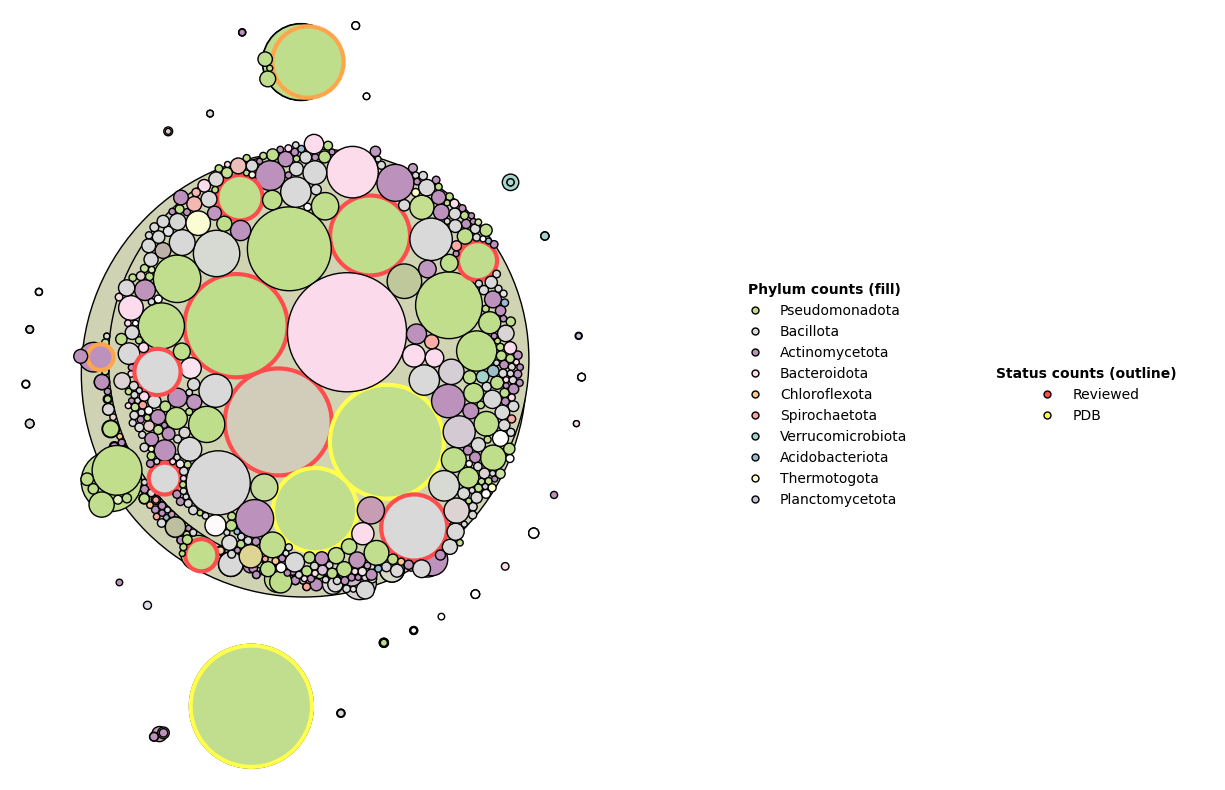

In [26]:
fig=cp.ExportFigure(layout, plot_data1, size=8)

In [102]:
fig.savefig('figures/mmseqs_137-196-303_phylum_status.pdf', bbox_inches='tight')